In [7]:
import torch
import json
import pandas as pd
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch.utils.data import random_split
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, Node2Vec

In [8]:
device = device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
call_graph_path = "/mnt/c/supervised_call_graphs/supervised_call_graphs.json"
labels_path = "/mnt/c/supervised_call_graphs/supervised_dataset.csv"

with open(call_graph_path, 'r') as file:
    data = json.load(file)

df = pd.read_csv(labels_path)
labels = df[['_id', 'classification']].values.tolist()

cuda


In [ ]:
dataset = []
for i in range(len(data)):
    node_to_index = {}
    for edge in data[i]["call_graph"]:
        if edge["fromId"] not in node_to_index:
            node_to_index[edge["fromId"]] = len(node_to_index)
        if edge["toId"] not in node_to_index:
            node_to_index[edge["toId"]] = len(node_to_index)
        
    edges = []
    for edge in data[i]["call_graph"]:
        from_idx = node_to_index[edge["fromId"]]
        to_idx = node_to_index[edge["toId"]]
        edges.append([from_idx, to_idx])

    if data[i]["_id"] != labels[i][0]:
        print('label _id error')
        break

    if len(edges) == 0:
        print(f"Graph {i} has no edges, dropped.")
        continue
    

    # Transposes to form where first row is to, second row is from; Coordinate List format (COO)
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    # Defines parameters for node2Vec model for creating node embeddings
    node2Vec_model = Node2Vec(edge_index=edge_index, 
                              embedding_dim=8, 
                              walk_length=20, 
                              context_size=10, 
                              walks_per_node=10, 
                              p=1, # p,q = 1 results in first order random walk (unbaised)
                              q=1,
                              sparse=True
                             ).to(device)
    node2Vec_loader = node2Vec_model.loader(batch_size=128, shuffle=True)
    node2Vec_optimizer = torch.optim.SparseAdam(list(node2Vec_model.parameters()), lr=0.01)

    node2Vec_model.train()
    for epoch in range(50):
        total_loss = 0
        for pos_rw, neg_rw in node2Vec_loader:
            node2Vec_optimizer.zero_grad()
            loss = node2Vec_model.loss(pos_rw.to(device), neg_rw.to(device))
            loss.backward()
            node2Vec_optimizer.step()
            total_loss += loss.item()

    embeddings = node2Vec_model(torch.arange(edge_index.max() + 1, device=device))
    y = torch.tensor([1 if labels[i][1] == 'outlier' else 0], dtype=torch.long)
    graph_data = Data(x=embeddings, edge_index=edge_index, num_nodes=len(node_to_index), y=y)
    dataset.append(graph_data)
    print(f'Graph {i}, Loss: {total_loss:.4f}')

In [9]:
#torch.save(dataset, '/mnt/c/supervised_call_graphs/node2vec_dataset_.pt')
dataset = torch.load('/mnt/c/supervised_call_graphs/node2vec_dataset_16.pt', weights_only=False)
train_len = int(0.8 * len(dataset))
val_len = len(dataset) - train_len
train_dataset, val_dataset = random_split(dataset, [train_len, val_len])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [10]:
class GNNModel(torch.nn.Module):
    def __init__(self):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(16, 8)
        self.conv2 = GCNConv(8, 8)
        self.dropout = torch.nn.Dropout(p=0.6)
        self.fc = torch.nn.Linear(8, 2)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index) # Relu is not needed when outputing to pooling layer
        x = self.dropout(x)
        x = global_mean_pool(x, batch) # Pooling to get graph-level representation
        return self.fc(x)


model = GNNModel().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-3) # L2 regularization
criterion = torch.nn.CrossEntropyLoss()

GNN_train_loss = []
GNN_val_loss = []
GNN_train_accuracy = []
GNN_val_accuracy = []

epochs = 30
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_train = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pred = out.argmax(dim=1)
        correct_train += (pred == batch.y).sum().item()
    
    avg_train_loss = total_loss / len(train_loader)
    train_acc = correct_train / len(train_loader.dataset)
    GNN_train_loss.append(avg_train_loss)
    GNN_train_accuracy.append(train_acc)

    model.eval()
    total_val_loss = 0
    correct_val = 0
    for batch in val_loader:
        batch = batch.to(device)
        out = model(batch)
        val_loss = criterion(out, batch.y)
        total_val_loss += val_loss.item()
        
        pred = out.argmax(dim=1)
        correct_val += (pred == batch.y).sum().item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_acc = correct_val / len(val_loader.dataset)
    GNN_val_loss.append(avg_val_loss)
    GNN_val_accuracy.append(val_acc)

    print(f'Epoch {epoch+1}, Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}')

Epoch 1, Training Accuracy: 0.6723, Validation Accuracy: 0.6726
Epoch 2, Training Accuracy: 0.7122, Validation Accuracy: 0.7109
Epoch 3, Training Accuracy: 0.7528, Validation Accuracy: 0.7404
Epoch 4, Training Accuracy: 0.7609, Validation Accuracy: 0.7581
Epoch 5, Training Accuracy: 0.7720, Validation Accuracy: 0.7729
Epoch 6, Training Accuracy: 0.7587, Validation Accuracy: 0.7552
Epoch 7, Training Accuracy: 0.7683, Validation Accuracy: 0.7758
Epoch 8, Training Accuracy: 0.7779, Validation Accuracy: 0.7876
Epoch 9, Training Accuracy: 0.7756, Validation Accuracy: 0.7758
Epoch 10, Training Accuracy: 0.7838, Validation Accuracy: 0.7876
Epoch 11, Training Accuracy: 0.7838, Validation Accuracy: 0.7758
Epoch 12, Training Accuracy: 0.7845, Validation Accuracy: 0.7847
Epoch 13, Training Accuracy: 0.7830, Validation Accuracy: 0.7788
Epoch 14, Training Accuracy: 0.7779, Validation Accuracy: 0.7876
Epoch 15, Training Accuracy: 0.7904, Validation Accuracy: 0.7847
Epoch 16, Training Accuracy: 0.789

In [11]:
# No GNN, fully connected layer makes predictions from node2vec embedding
class BaseModel(torch.nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.dropout = torch.nn.Dropout(p=0.6)
        self.fc = torch.nn.Linear(16, 2)

    def forward(self, data):
        x, batch = data.x, data.batch
        x = self.dropout(x)
        x = global_mean_pool(x, batch)
        return self.fc(x)

model = BaseModel().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

base_train_loss = []
base_val_loss = []
base_train_accuracy = []
base_val_accuracy = []

epochs = 30
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_train = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pred = out.argmax(dim=1)
        correct_train += (pred == batch.y).sum().item()
    
    avg_train_loss = total_loss / len(train_loader)
    train_acc = correct_train / len(train_loader.dataset)
    base_train_loss.append(avg_train_loss)
    base_train_accuracy.append(train_acc)

    model.eval()
    total_val_loss = 0
    correct_val = 0
    for batch in val_loader:
        batch = batch.to(device)
        out = model(batch)
        val_loss = criterion(out, batch.y)
        total_val_loss += val_loss.item()
        
        pred = out.argmax(dim=1)
        correct_val += (pred == batch.y).sum().item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_acc = correct_val / len(val_loader.dataset)
    base_val_loss.append(avg_val_loss)
    base_val_accuracy.append(val_acc)

    print(f'Epoch {epoch+1}, Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}')


Epoch 1, Training Accuracy: 0.5609, Validation Accuracy: 0.6637
Epoch 2, Training Accuracy: 0.6627, Validation Accuracy: 0.6519
Epoch 3, Training Accuracy: 0.6627, Validation Accuracy: 0.6490
Epoch 4, Training Accuracy: 0.6679, Validation Accuracy: 0.6490
Epoch 5, Training Accuracy: 0.6657, Validation Accuracy: 0.6519
Epoch 6, Training Accuracy: 0.6716, Validation Accuracy: 0.6549
Epoch 7, Training Accuracy: 0.6738, Validation Accuracy: 0.6519
Epoch 8, Training Accuracy: 0.6731, Validation Accuracy: 0.6519
Epoch 9, Training Accuracy: 0.6745, Validation Accuracy: 0.6490
Epoch 10, Training Accuracy: 0.6708, Validation Accuracy: 0.6490
Epoch 11, Training Accuracy: 0.6679, Validation Accuracy: 0.6490
Epoch 12, Training Accuracy: 0.6649, Validation Accuracy: 0.6490
Epoch 13, Training Accuracy: 0.6672, Validation Accuracy: 0.6519
Epoch 14, Training Accuracy: 0.6657, Validation Accuracy: 0.6490
Epoch 15, Training Accuracy: 0.6598, Validation Accuracy: 0.6490
Epoch 16, Training Accuracy: 0.659

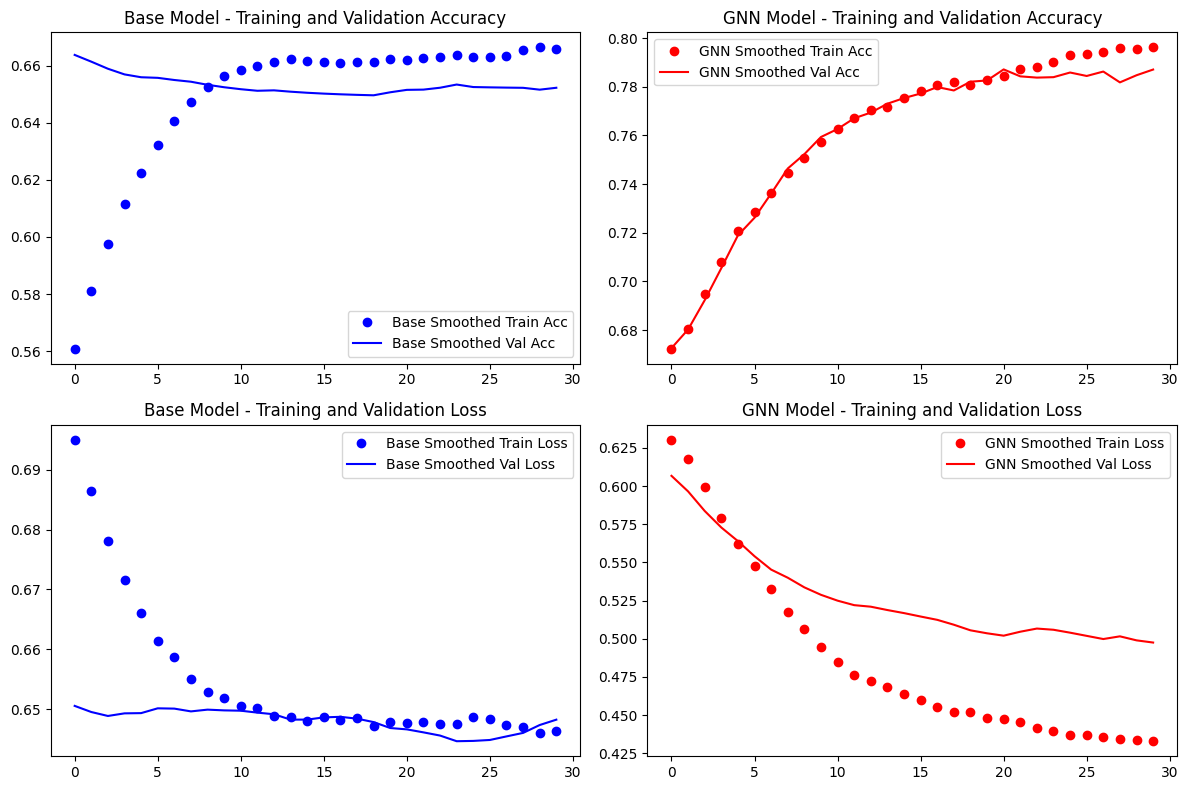

In [12]:
import matplotlib.pyplot as plt

def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

epochs = range(len(GNN_train_accuracy))

# Plot Training and Validation Accuracy for both models
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(epochs, smooth_curve(base_train_accuracy), 'bo', label='Base Smoothed Train Acc')
plt.plot(epochs, smooth_curve(base_val_accuracy), 'b', label='Base Smoothed Val Acc')
plt.title('Base Model - Training and Validation Accuracy')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, smooth_curve(GNN_train_accuracy), 'ro', label='GNN Smoothed Train Acc')
plt.plot(epochs, smooth_curve(GNN_val_accuracy), 'r', label='GNN Smoothed Val Acc')
plt.title('GNN Model - Training and Validation Accuracy')
plt.legend()

# Plot Training and Validation Loss for both models
plt.subplot(2, 2, 3)
plt.plot(epochs, smooth_curve(base_train_loss), 'bo', label='Base Smoothed Train Loss')
plt.plot(epochs, smooth_curve(base_val_loss), 'b', label='Base Smoothed Val Loss')
plt.title('Base Model - Training and Validation Loss')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, smooth_curve(GNN_train_loss), 'ro', label='GNN Smoothed Train Loss')
plt.plot(epochs, smooth_curve(GNN_val_loss), 'r', label='GNN Smoothed Val Loss')
plt.title('GNN Model - Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()
